In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../..")
import pandas as pd
from KETIPreDataIngestion.KETI_setting import influx_setting_KETI as ins
from KETIPreDataIngestion.data_influx.influx_Client import influxClient
import matplotlib.pyplot as plt

### 1. Data Preparation

In [2]:
feature =['in_pm10','in_pm10_raw', 'in_pm25', 'in_pm25_raw', 'in_temp', 'in_voc']
# Influx
method ="influx"
if method =="influx":
    #Influx
    from KETIPreDataIngestion.KETI_setting import influx_setting_KETI as ins
    from KETIPreDataIngestion.data_influx.influx_Client import influxClient
    db_name = "air_indoor_경로당"
    ms_name = "ICL1L2000234"
    number =20000
    DBClient = influxClient(ins.CLUSTDataServer)
    #original = DBClient.get_dataend_by_num(number, db_name, ms_name)
    original = DBClient.get_datafront_by_num(number, db_name, ms_name) 
    #data = original[feature]
    data = original
    period = 24*60

elif method =='file':
    # File
    data_dir = './data/uci_har_outlier_data.csv'
    data = pd.read_csv(data_dir) # shape: [10299, 40]
    data.index = pd.date_range(start='1/1/2018', end='1/08/2018', periods = len(test_signal))
    period = 24
else:
    # Generate test data
    import numpy as np
    period = 24
    test_signal = np.concatenate(
        [np.random.normal(0.7, 0.05, 300), 
         np.random.normal(1.5, 0.05, 300),
         np.random.normal(0.6, 0.05, 300),
         np.random.normal(1.3, 0.05, 300)])
    data = pd.DataFrame(test_signal, columns=['test'], index = pd.date_range(start='1/1/2018', end='1/08/2018', periods = len(test_signal)))




*****************************cleanup problem***********************========================
                       time  in_ciai  in_cici  in_cici_co2  in_cici_humi  \
0      2021-02-04T10:33:00Z     53.0     57.0          0.0          80.0   
1      2021-02-04T10:34:00Z     67.0     60.0         88.0          54.0   
2      2021-02-04T10:35:00Z     69.0     65.0         87.0          50.0   
3      2021-02-04T10:36:00Z     73.0     66.0         88.0          47.0   
4      2021-02-04T10:37:00Z     76.0     69.0         89.0          47.0   
...                     ...      ...      ...          ...           ...   
19995  2021-02-18T08:37:00Z     91.0     91.0         91.0          39.0   
19996  2021-02-18T08:38:00Z     91.0     91.0         91.0          39.0   
19997  2021-02-18T08:39:00Z     91.0     91.0         91.0          39.0   
19998  2021-02-18T08:40:00Z     91.0     91.0         91.0          39.0   
19999  2021-02-18T08:41:00Z     91.0     91.0         91.0          39.

In [3]:
## Outlier Detector
AlgorithmList =[ 'IF', 'KDE', 'LOF', 'MoG', 'SR', 'IQR', 'SD']
algorithm1 = AlgorithmList[4] # IF 는 무조건 1에서만 고를 것
percentile1 = 99
algorithm2 = AlgorithmList[3]
percentile2 = 99
algorithm2 = AlgorithmList[0]
percentile2 = 99

Parameter = {
    "IF":{ # Estimators (1~100)
        'IF_estimators': 100, # ensemble에 활용하는 모델 개수, i(default: 100, 데이터 크기에 적합하게 설정) 
        'IF_max_samples': 'auto', # 각 모델에 사용하는 샘플 개수(샘플링 적용), int or float(default: 'auto') 
        'IF_contamination': (100-percentile1)/100, #'auto', # 모델 학습시 활용되는 데이터의 outlier 비율, ‘auto’ or float(default: ’auto’, float인 경우 0 초과, 0.5 이하로 설정)
        'IF_max_features': 1.0, # 각 모델에 사용하는 변수 개수(샘플링 적용), int or float(default: 1.0)
        'IF_bootstrap': False}, # bootstrap적용 여부, bool(default: False)
    "KDE":{ #leafSize (1~100)
        # Multivariable 가능
        'KDE_bandwidth': 1.0, # kernel의 대역폭, float(default: 1.0)
        'KDE_algorithm': 'auto', # 사용할 tree 알고리즘, {‘kd_tree’,‘ball_tree’,‘auto’}(default: ’auto’) 중 택 1
        'KDE_kernel': 'gaussian', # kernel 종류, {'gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}(default: ’gaussian’) 중 택 1
        'KDE_metric': 'euclidean', # 사용할 거리 척도, str(default: ’euclidean’)
        'KDE_breadth_first': True, # breadth(너비) / depth(깊이) 중 우선순위 방식 정의, bool, True: breadth or False: depth
        'KDE_leaf_size': 40}, # tree 알고리즘에서의 leaf node 개수, int(default: 40)}
    "LOF":{ # Neighbors (1~100) , leafSize (1~100, Integer)
        'LOF_neighbors': 100, # 가까운 이웃 개수, int(default: 20)
        'LOF_algorithm': 'auto', # 가까운 이웃을 정의하기 위한 알고리즘, {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}(default: ’auto’) 중 택 1
        'LOF_leaf_size': 30, # tree 알고리즘에서의 leaf node 개수, int(default: 30)
        'LOF_metric': 'minkowski', # 이웃을 정의하기 위한 거리 척도, str or callable(default: ’minkowski’)
        'LOF_contamination':0.1 # 오염 정도 (default: 0.2) (0~0.2]
    },
    "MoG": { #Components(1~100)
        'MoG_components': 3, # mixture에 활용하는 component의 개수, int(default: 1)
        'MoG_covariance': 'full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}(default: ’full’) 중 택 1
        'MoG_max_iter': 100 # EM 방법론 반복 횟수, int(default: 100)
    },
    "SR":{ 
        # Multivariable 불가능해 보임
        'SR_series_window_size': int(period/2), # less than period, int, 데이터 크기에 적합하게 설정
        'SR_spectral_window_size': period, # as same as period, int, 데이터 크기에 적합하게 설정
        'SR_score_window_size': period *2}, # a number enough larger than period, int, period보다 충분히 큰 size로 설정
    "IQR":{ # weight (1~100)
        'weight':100},
    "SD":{# limit (1~100)
        "period":period, "limit":15}
    
}

### 2. Outlier Detection

In [4]:
from KETIPrePartialDataPreprocessing.error_detection.unCertainError import unCertainErrorRemove
from KETIPrePartialDataPreprocessing.error_detection import dataOutlier

UncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': algorithm1, 'percentile':percentile1 ,'alg_parameter': Parameter[algorithm1]},
    {'algorithm': algorithm2, 'percentile':percentile2 ,'alg_parameter': Parameter[algorithm2]}
]}
UncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': algorithm1, 'percentile':percentile1 ,'alg_parameter': Parameter[algorithm1]}
]}

In [39]:
data_outlier = unCertainErrorRemove(data, UncertainParameter)
outlierIndex = data_outlier.getNoiseIndex()
result = data_outlier.getDataWithoutUncertainError(outlierIndex)

{'algorithm': 'SR', 'percentile': 99, 'alg_parameter': {'SR_series_window_size': 720, 'SR_spectral_window_size': 1440, 'SR_score_window_size': 2880}}
SR


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 75.69it/s]


In [40]:
data_outlier.outlierIndex

{'SR': {'in_ciai': DatetimeIndex(['2021-02-04 18:11:00+00:00', '2021-02-04 18:13:00+00:00',
                 '2021-02-04 18:15:00+00:00', '2021-02-05 06:11:00+00:00',
                 '2021-02-05 06:12:00+00:00', '2021-02-05 06:13:00+00:00',
                 '2021-02-05 06:14:00+00:00', '2021-02-05 06:15:00+00:00',
                 '2021-02-05 06:16:00+00:00', '2021-02-05 06:17:00+00:00',
                 ...
                 '2021-02-17 18:12:00+00:00', '2021-02-17 18:13:00+00:00',
                 '2021-02-17 18:14:00+00:00', '2021-02-17 18:15:00+00:00',
                 '2021-02-17 18:16:00+00:00', '2021-02-17 18:17:00+00:00',
                 '2021-02-18 06:11:00+00:00', '2021-02-18 06:12:00+00:00',
                 '2021-02-18 06:14:00+00:00', '2021-02-18 06:16:00+00:00'],
                dtype='datetime64[ns, UTC]', name='time', length=201, freq=None),
  'in_cici': DatetimeIndex(['2021-02-04 18:10:00+00:00', '2021-02-04 18:11:00+00:00',
                 '2021-02-04 18:12:00+00:00

In [41]:
intersectionIndex = data_outlier.getIntersectionIndex(outlierIndex)

in_ciai


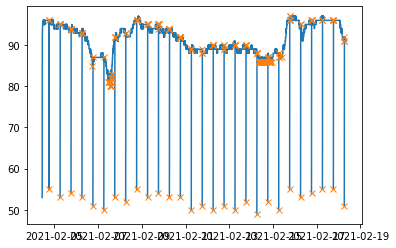

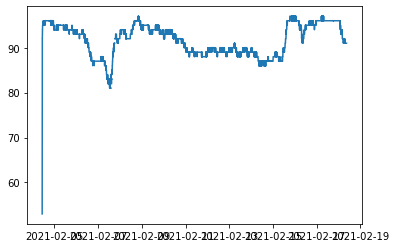

in_cici


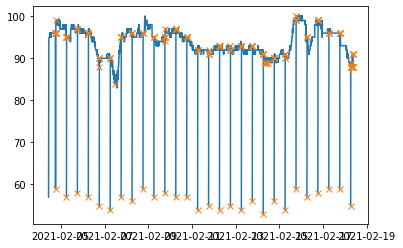

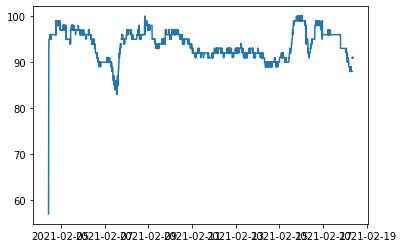

in_cici_co2


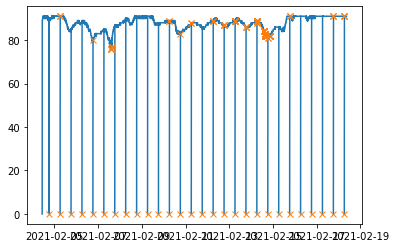

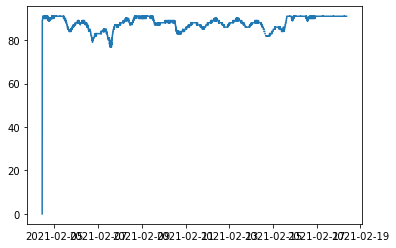

in_cici_humi


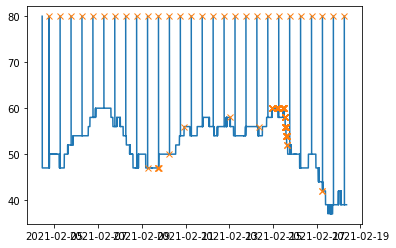

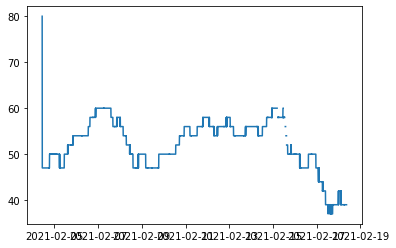

in_cici_noise


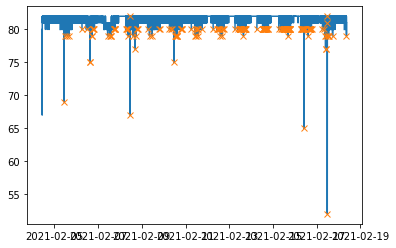

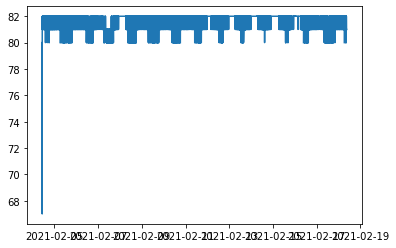

in_cici_pm10


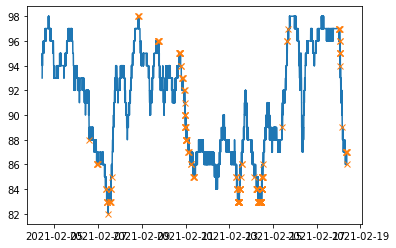

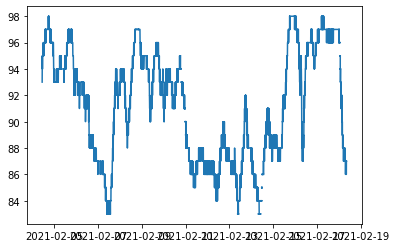

in_cici_pm25


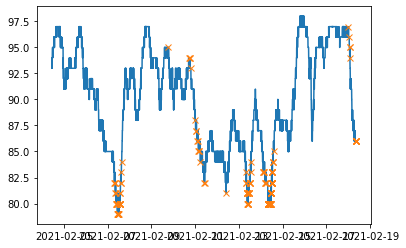

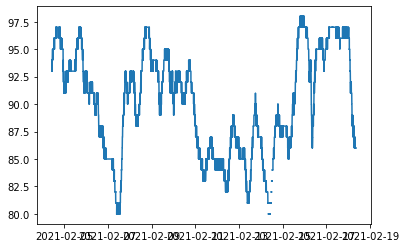

in_cici_temp


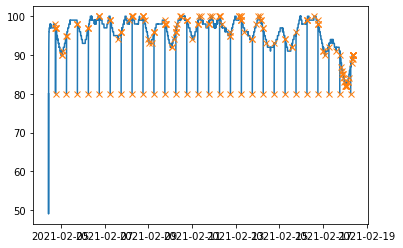

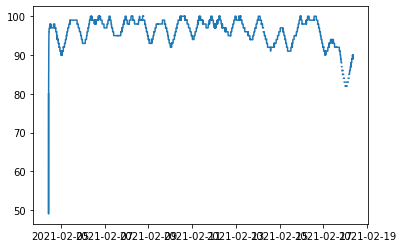

in_cici_voc


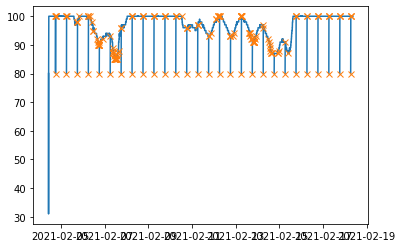

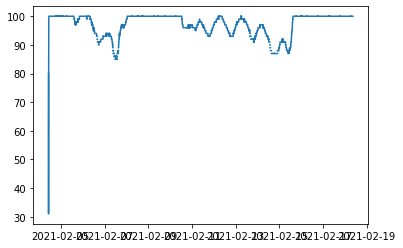

in_co2


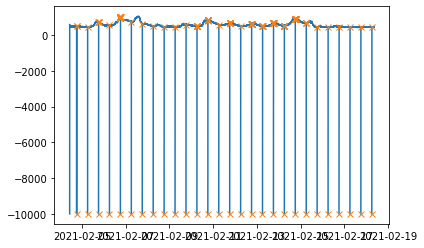

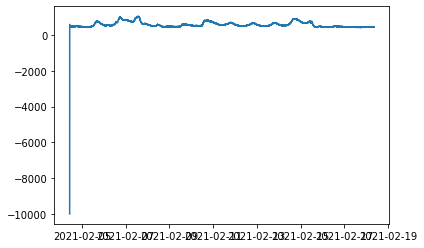

in_humi


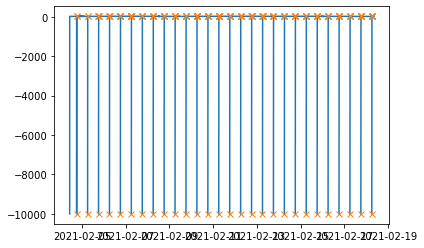

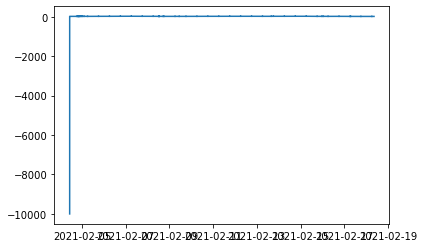

in_noise


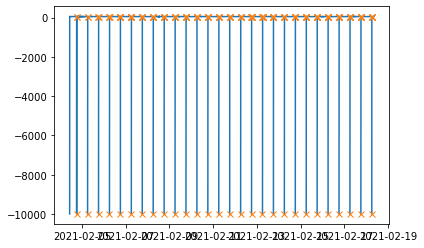

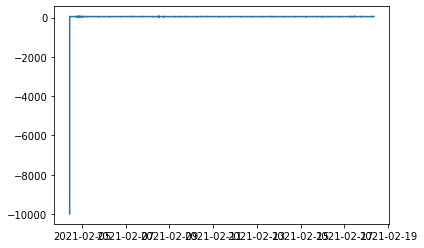

in_pm01


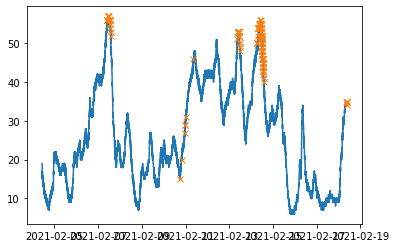

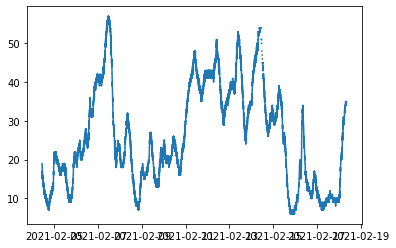

in_pm01_raw


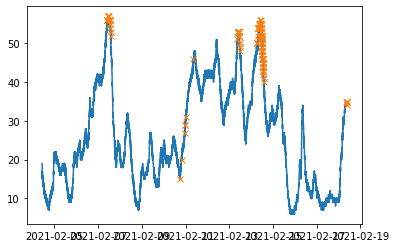

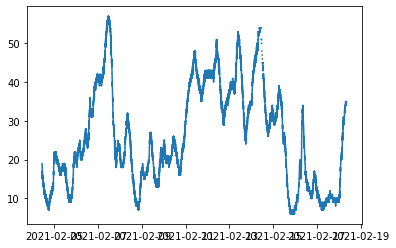

in_pm10


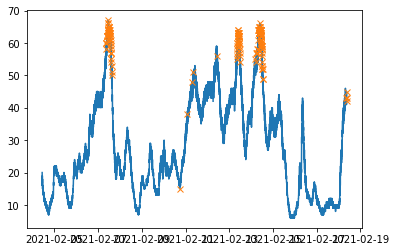

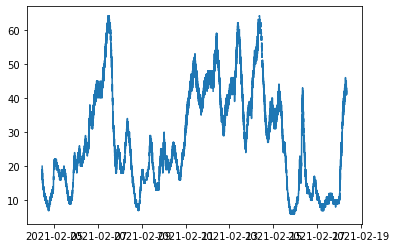

in_pm10_raw


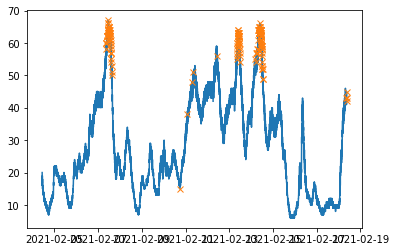

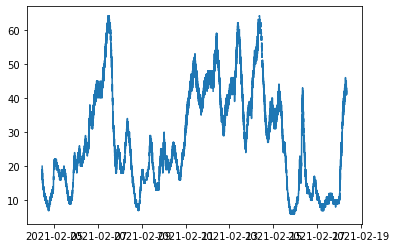

in_pm25


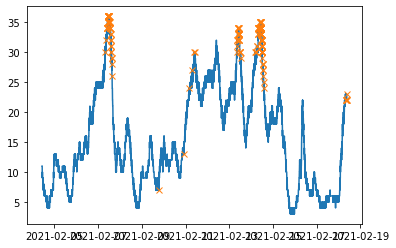

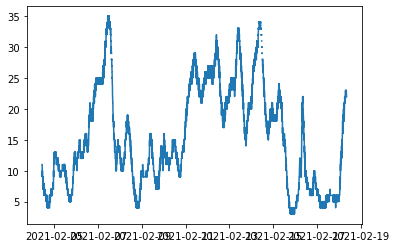

in_pm25_raw


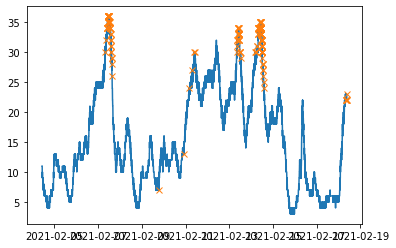

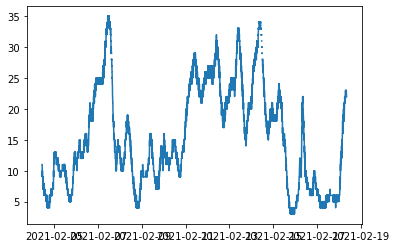

in_temp


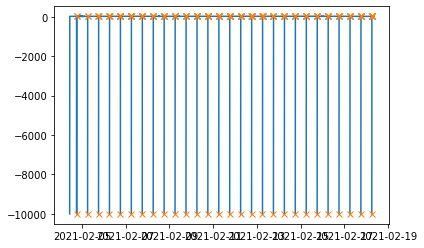

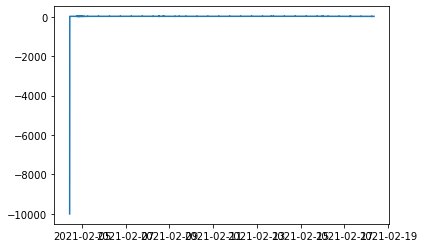

in_voc


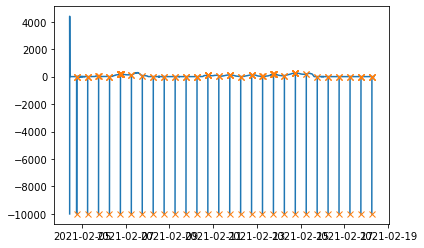

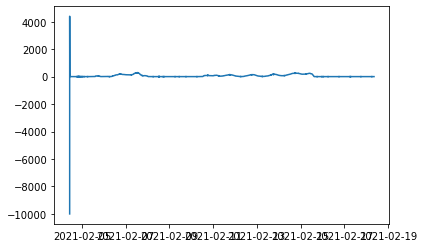

In [42]:
dataOutlier.showResult(data_outlier.data, result, outlierIndex)

{'algorithm': 'SR', 'percentile': 99, 'alg_parameter': {'SR_series_window_size': 720, 'SR_spectral_window_size': 1440, 'SR_score_window_size': 2880}}
SR


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 71.92it/s]


in_ciai


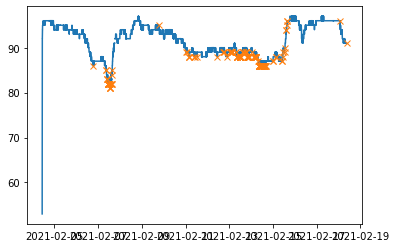

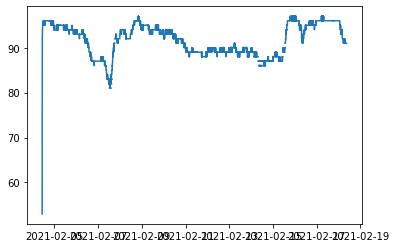

in_cici


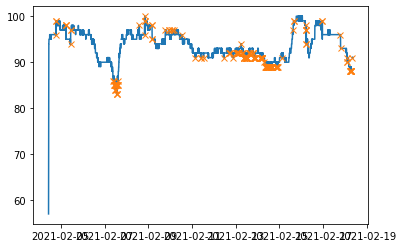

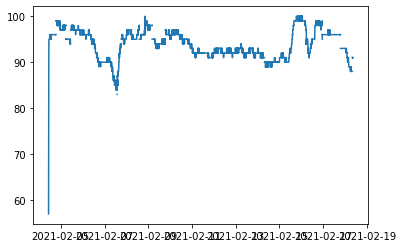

in_cici_co2


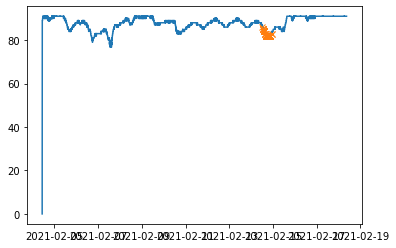

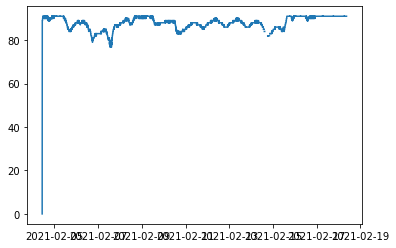

in_cici_humi


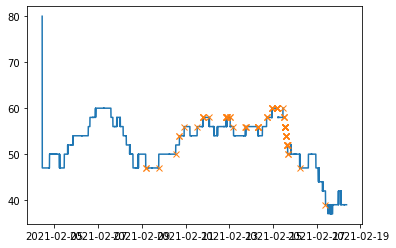

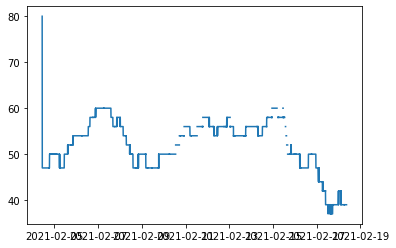

in_cici_noise


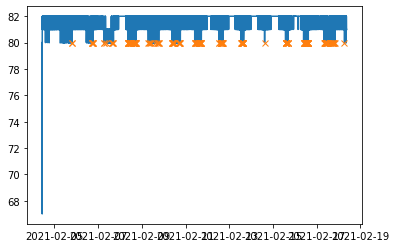

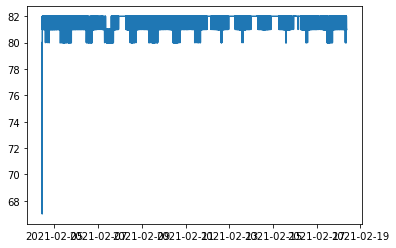

in_cici_pm10


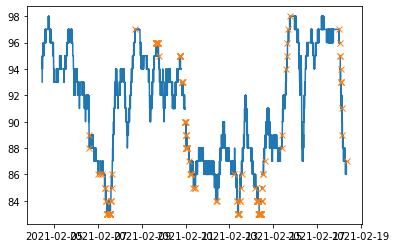

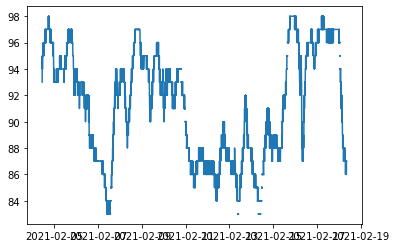

in_cici_pm25


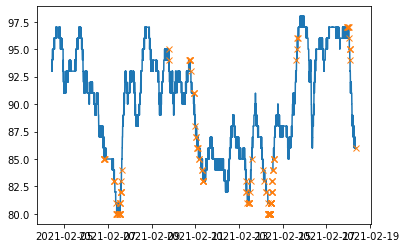

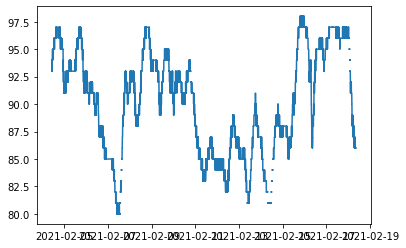

in_cici_temp


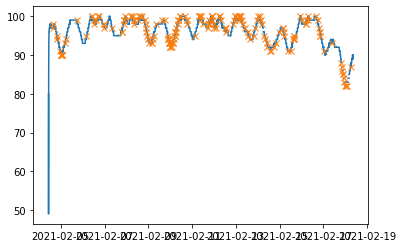

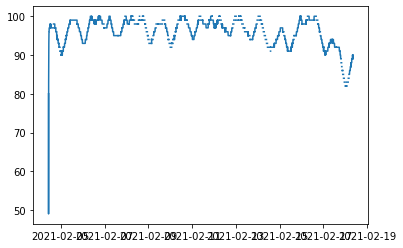

in_cici_voc


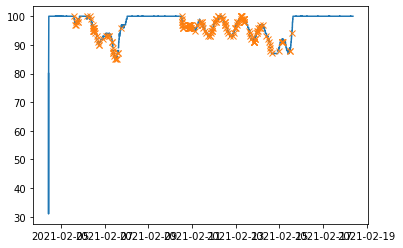

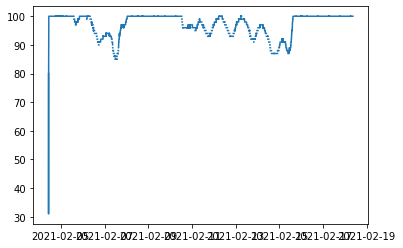

in_co2


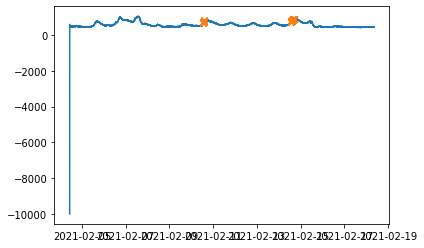

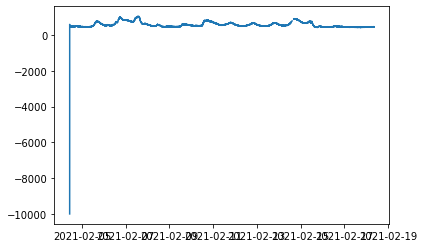

in_humi


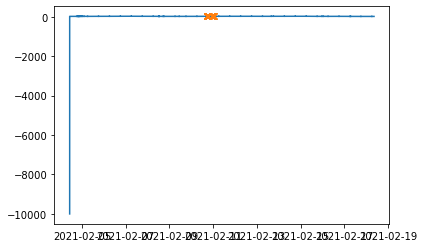

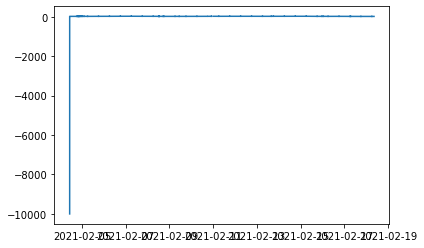

in_noise


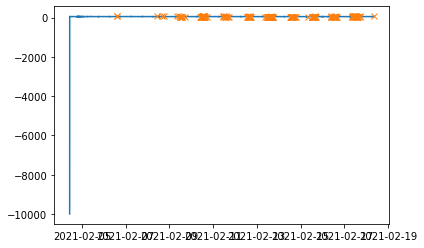

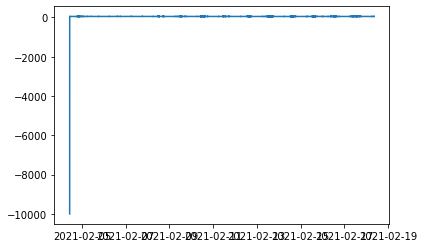

in_pm01


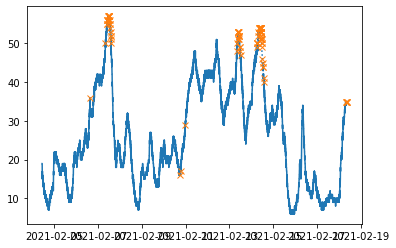

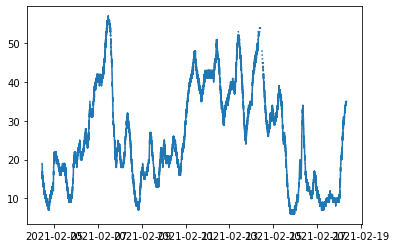

in_pm01_raw


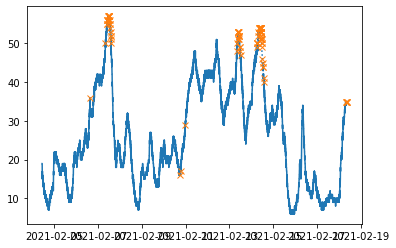

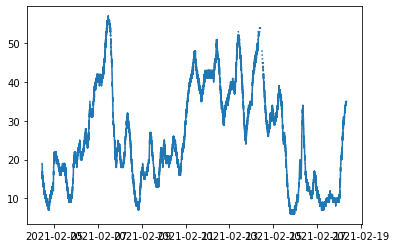

in_pm10


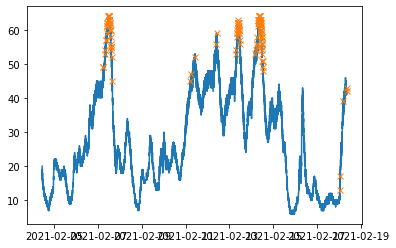

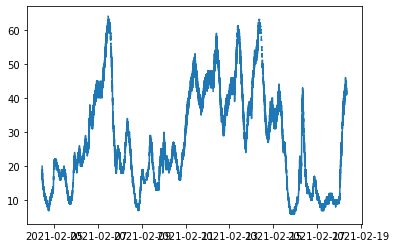

in_pm10_raw


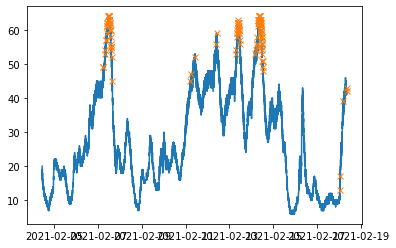

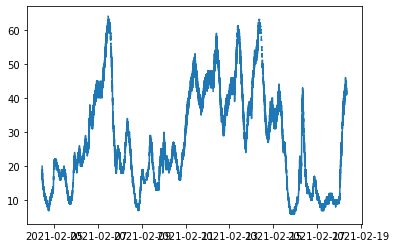

in_pm25


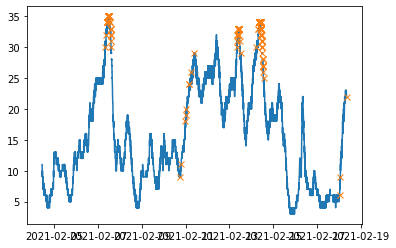

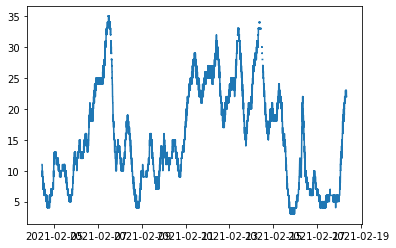

in_pm25_raw


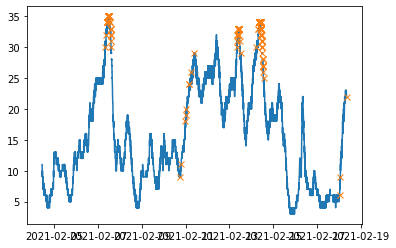

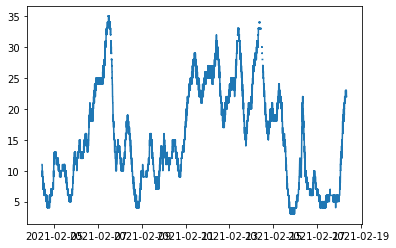

in_temp


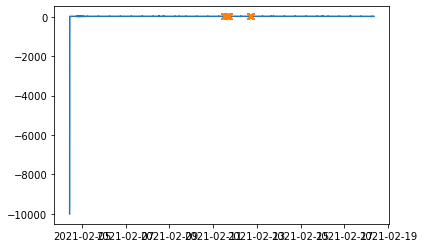

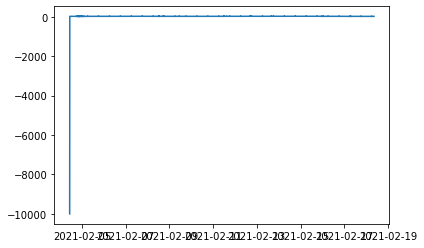

in_voc


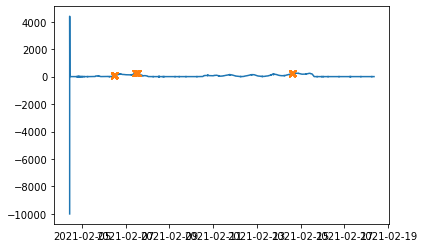

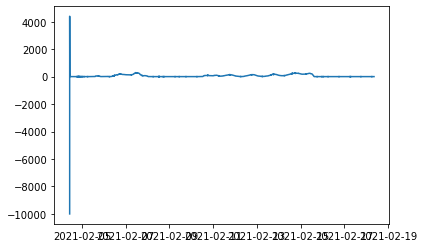

In [43]:
# 0ne more

data_outlier = unCertainErrorRemove(result, UncertainParameter)
outlierIndex = data_outlier.getNoiseIndex()
result = data_outlier.getDataWithoutUncertainError(outlierIndex)
dataOutlier.showResult(data_outlier.data, result, outlierIndex)